Particle image velocimetry using cross-correlation

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread

Let us first load the images and find out the size of the images for later reference

In [51]:
a = imread("B001_1.tif")
b = imread("B001_2.tif")
print("The size of the image: ")
print(np.shape(a))

The size of the image: 
(512, 512)


We can now convert the images from RGB (if present) to a grayscale value. In this case, we can show the two images side by side. A quick scroll of the two images in a software such as irfanview reveals the present of motion of the fluid owing to which the seeding particles move. The successive images allow us to make this distinction. Arguably, the human mind is very efficient in demarcating motion from such kinds of particle 'flows'. 

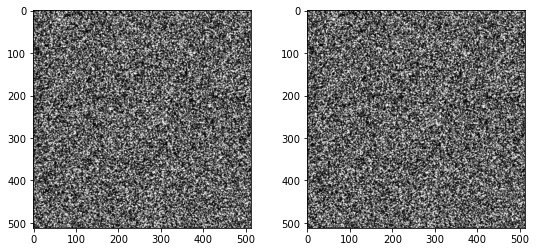

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
axs[0].imshow(a, cmap=plt.cm.gray)
axs[1].imshow(b, cmap=plt.cm.gray)
plt.show()

The idea of this message is that over a small time difference, the two frames do not differ by a large quantity. In such a case, if we can identify a patter in the first images, and then try to match the pattern in the second image, we can find out the direction in which the two patterns correlate quite well. 

Let us now perform a cross correlation manually between the two images. In this case, we must subdivide the image into smaller sized section. In which follows, we choose a window size of 32

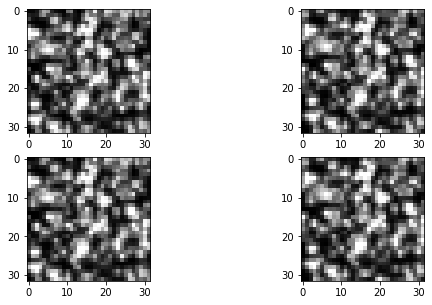

In [53]:
win_size = 32

a_win= a[:win_size, :win_size].copy()
b_win= b[:win_size, :win_size].copy()

fig, axs = plt.subplots(2, 2, figsize=(9,5))
axs[0,0].imshow(a_win, cmap=plt.cm.gray)
axs[0,1].imshow(b_win, cmap=plt.cm.gray)
axs[1,0].imshow(a_win-np.mean(a_win), cmap = plt.cm.gray)
axs[1,1].imshow(b_win-np.mean(b_win), cmap = plt.cm.gray)
plt.show()

Size of the correlation map: 63 x 63


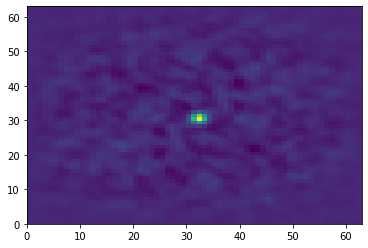

In [65]:
from scipy.signal import correlate
cross_corr = correlate(b_win-np.mean(b_win), a_win-np.mean(a_win), method="fft")
print("Size of the correlation map: %d x %d" % cross_corr.shape)
plt.pcolor(cross_corr)

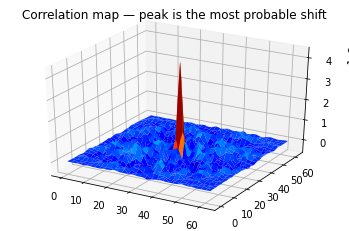

In [66]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
Y, X = np.meshgrid(np.arange(cross_corr.shape[0]), np.arange(cross_corr.shape[1]))

ax.plot_surface(Y, X, cross_corr, cmap='jet', linewidth=0.2)  # type: ignore
plt.title("Correlation map — peak is the most probable shift")
plt.show()

y=30, x=32


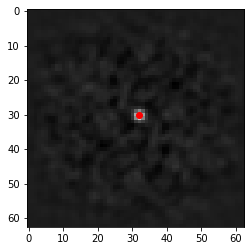

In [67]:
plt.imshow(cross_corr, cmap=plt.cm.gray)
y, x = np.unravel_index(cross_corr.argmax(), cross_corr.shape)
print(f"{y=}, {x=}")

plt.plot(x, y, "ro")
plt.show()

In [71]:
def vel_field(curr_frame, next_frame, win_size):
    ys = np.arange(0, curr_frame.shape[0], win_size)
    xs = np.arange(0, curr_frame.shape[1], win_size)
    dys = np.zeros((len(ys),len(xs)))
    dxs = np.zeros((len(ys),len(xs)))
    for iy, y in enumerate(ys):
        for ix, x in enumerate(xs):
            int_win = curr_frame[y:y+win_size, x:x+win_size]
            search_win= next_frame[y:y+win_size, x:x+win_size]
            cross_corr= correlate(search_win- search_win.mean(), int_win - int_win.mean(), method = "fft")
            dys[iy, ix], dxs[iy, ix] = (np.unravel_index(np.argmax(cross_corr), cross_corr.shape)- np.array([win_size, win_size])+1)
    ys= ys+win_size/2
    xs= xs+win_size/2
    return xs, ys, dxs, dys
        

In [74]:
ms = np.arange(0,15,3)
print(ms)
for iz, z in enumerate(ms):
    print(iz, z)
print(np.array([win_size, win_size])-1)
print(np.unravel_index(np.argmax(cross_corr), cross_corr.shape)- np.array([win_size, win_size])+1)

[ 0  3  6  9 12]
0 0
1 3
2 6
3 9
4 12
[31 31]
[-1  1]


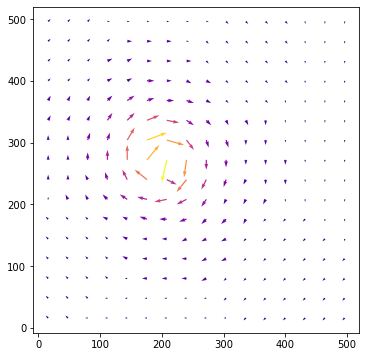

In [73]:
xs, ys, dxs, dys = vel_field(a, b, 32)
norm_drs= np.sqrt(dxs**2 +dys**2)

fig, ax = plt.subplots(figsize=(6,6))
ax.quiver(xs, ys[::-1], dxs, -dys, norm_drs, cmap= "plasma", angles="xy", scale_units="xy", scale=0.25,)
ax.set_aspect("equal")
plt.show()